In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PySimpleGUI as sg

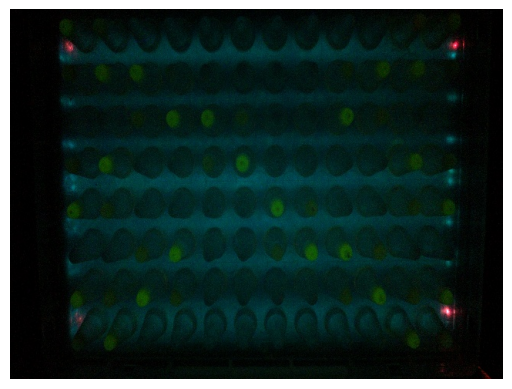

In [105]:
Img = "../data/images_06_11/Repaire.jpg"
imageInput = cv2.imread(Img)
imageInputRGB = cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(imageInputRGB)
plt.axis('off')  # Optional: to hide axis
plt.show()

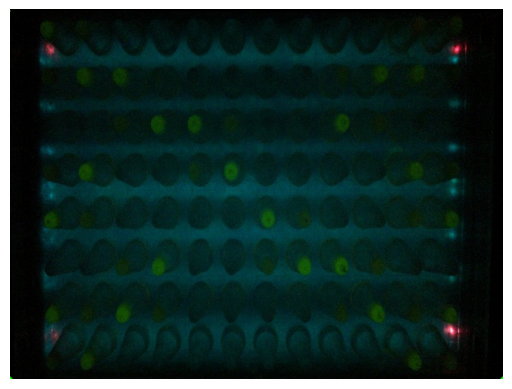

In [104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def correct_perspective(imageInput):
    blurred_image = cv2.GaussianBlur(imageInput, (15, 15), 0)

    # Set blue and green channels to 0, leaving only the red channel
    blurred_image[:, :, 0] = 0
    blurred_image[:, :, 1] = 0

    red_channel = blurred_image[:, :, 2]

    # Apply thresholding
    _, thresholded = cv2.threshold(red_channel, 20, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    min_contour_area = 150
    shifted_corners = []  # Store shifted corners for perspective transformation

    # Define the reference point for shifting corners
    reference_point = (260, 200)
    
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area >= min_contour_area:
            M = cv2.moments(contour)

            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))

                # Get bounding box around the contour
                x, y, w, h = cv2.boundingRect(contour)

                # Define shift amount for corners
                shift = 40

                # Define the four corners of the bounding box
                top_left = (x - shift, y - shift)
                top_right = (x + w + shift, y - shift)
                bottom_left = (x - shift, y + h + shift)
                bottom_right = (x + w + shift, y + h + shift)

                # Decide which corner to shift based on the reference point
                if x < reference_point[0] and y < reference_point[1]:
                    shifted_corner = top_left
                elif x > reference_point[0] and y < reference_point[1]:
                    shifted_corner = top_right
                elif x < reference_point[0] and y > reference_point[1]:
                    shifted_corner = bottom_left
                else:
                    shifted_corner = bottom_right

                shifted_corners.append(shifted_corner)

    # Ensure the shifted corners array has at least 4 points
    if len(shifted_corners) >= 4:
        # Convert shifted corners to numpy array (float32)
        shifted_corners = np.array(shifted_corners[:4], dtype='float32')

        # Define the original corner points of the image
        height, width = imageInput.shape[:2]
        original_corners = np.array([
            [0, height - 1],      # bottom-left
            [width - 1, height - 1],  # bottom-right
            [0, 0],               # top-left
            [width - 1, 0],       # top-right
        ], dtype='float32')

        # Compute the perspective transform matrix
        perspective_matrix = cv2.getPerspectiveTransform(shifted_corners, original_corners)

        # Perform the perspective transformation (this effectively crops the image based on the shifted corners)
        transformed_image = cv2.warpPerspective(imageInput, perspective_matrix, (width, height))

        return transformed_image  # Return the perspective-corrected image

    else:
        print("Not enough shifted corners for transformation.")
        return imageInput  # Return the original image if not enough corners

# Example usage:
corrected_image = correct_perspective(imageInput)

# Display the corrected image
plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


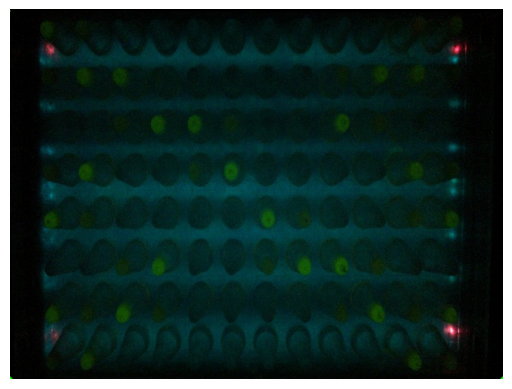

In [107]:
imageInput = corrected_image
imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput_blurred, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Create binary mask based on threshold
threshold_value = 1
_, binary_mask = cv2.threshold(b, threshold_value, 255, cv2.THRESH_BINARY)

# Remove small noise using contour detection
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 200  # Adjust this value to control the noise filter size

# Filter out small contours
for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(binary_mask, [contour], -1, 0, -1)  # Fill small areas with black

# Enhance contrast of the filtered binary mask for better visibility
contrast_enhanced = cv2.convertScaleAbs(binary_mask, alpha=2, beta=0)

# Darken the original image
darkened_image = cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0)

# Convert the binary mask to 3 channels for blending
binary_mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

# Use the binary mask to blend original and darkened image
overlayed_image = np.where(binary_mask_colored == 255, imageInput, darkened_image)

# Display the final result
plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [10]:
import cv2
import numpy as np

# Step 1: Thresholding the 'b' channel to isolate bright spots
_, thresh = cv2.threshold(b, 200, 255, cv2.THRESH_BINARY)

# Step 2: Find contours of the bright spots
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Calculate the center of each contour (this gives us the grid's bright spots)
centers = []
for contour in contours:
    # Get the center of each contour (moment method)
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centers.append((cx, cy))

# Step 4: Use clustering or average method to estimate grid lines
# Here, I'll use np.median to estimate positions of the grid lines for simplicity
if len(centers) > 0:
    # Extract x and y coordinates
    x_coords, y_coords = zip(*centers)
    
    # Estimate vertical and horizontal lines based on median positions of spots
    vertical_lines = np.percentile(x_coords, [10, 30, 50, 70, 90])  # Approximate vertical positions
    horizontal_lines = np.percentile(y_coords, [10, 30, 50, 70, 90])  # Approximate horizontal positions

    # Draw vertical lines
    for x in vertical_lines:
        cv2.line(imageInput, (int(x), 0), (int(x), height), (0, 255, 0), 2)
    
    # Draw horizontal lines
    for y in horizontal_lines:
        cv2.line(imageInput, (0, int(y)), (width, int(y)), (0, 255, 0), 2)

# Step 5: Show the result
cv2.imshow("Grid", imageInput)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
def color_grid(image, vertical_positions, horizontal_positions, cell_dict, binary_grid):
    for x in vertical_positions:
        cv2.line(image, (x, 0), (x, height), (255, 255, 255), 1)
    for y in horizontal_positions:
        cv2.line(image, (0, y), (width, y), (255, 255, 255), 1)

    grid_height = len(horizontal_positions) - 1
    grid_width = len(vertical_positions) - 1
    
    for i in range(grid_height):
        for j in range(grid_width):
            label = chr(65 + i) + str(j + 1)
            cell_dict[label] = {
                'x_start': vertical_positions[j],
                'x_end': vertical_positions[j + 1],
                'y_start': horizontal_positions[i],
                'y_end': horizontal_positions[i + 1]
            }
            
            # Get the color for the cell from the binary_grid
            text_color = (0, 255, 0) if binary_grid.get(label, 0) == 1 else (0, 0, 0)
            
            # Place the label on the image
            cv2.putText(image, label, 
                        (vertical_positions[j] + 5, horizontal_positions[i] + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, text_color, 1)
    
    return cell_dict

def draw_grid(image, vertical_positions, horizontal_positions):
    for x in vertical_positions:
        cv2.line(image, (x, 0), (x, height), (255, 255, 255), 1)
    for y in horizontal_positions:
        cv2.line(image, (0, y), (width, y), (255, 255, 255), 1)
    cell_dict = {}
    grid_height = len(horizontal_positions) - 1
    grid_width = len(vertical_positions) - 1
    binary_grid = {}
    for i in range(grid_height):
        for j in range(grid_width):
            label = chr(65 + i) + str(j + 1)
            cell_dict[label] = {
                'x_start': vertical_positions[j],
                'x_end': vertical_positions[j + 1],
                'y_start': horizontal_positions[i],
                'y_end': horizontal_positions[i + 1]
            }
    return cell_dict

##############

# Convert to LAB color space and apply Gaussian blur
imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput_blurred, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

# Get image dimensions and define grid positions
height, width, _ = imageInput.shape
vertical_positions = [35, 80, 128, 175, 215, 260, 310, 360, 405, 455, 500, 545, 595]
horizontal_positions = [0, 60, 120, 175, 235, 300, 360, 425, 475]

# Draw grid and get coordinates of each cell
overlayed_image = np.where(cv2.cvtColor(cv2.threshold(b, 153, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_GRAY2BGR) == 255, imageInput, cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0))
cell_dict = draw_grid(overlayed_image, vertical_positions, horizontal_positions)
a1_coords = cell_dict["A1"]
a1_b_channel = b[a1_coords['y_start']:a1_coords['y_end'], a1_coords['x_start']:a1_coords['x_end']]
threshold_value = int(np.max(a1_b_channel)) - int(np.max(a1_b_channel)) * 0.04  
print(threshold_value)
_, binary_mask = cv2.threshold(b, threshold_value, 255, cv2.THRESH_BINARY)

# Remove small noise using contour detection
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 150  # Minimum area to keep
for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(binary_mask, [contour], -1, 0, -1)

# Darken the original image and apply the mask
darkened_image = cv2.convertScaleAbs(imageInput, alpha=0.3, beta=0)
binary_mask_colored = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
overlayed_image = np.where(binary_mask_colored == 255, imageInput, darkened_image)

binary_grid = {}
for cell_name, cell_coords in cell_dict.items():
    # Crop the binary mask for the current cell
    cell_mask = binary_mask[cell_coords['y_start']:cell_coords['y_end'], cell_coords['x_start']:cell_coords['x_end']]
    
    # Count white pixels in the cell
    positive_pixels = cv2.countNonZero(cell_mask)
    
    # Mark as 1 if positive sample is detected, otherwise 0
    binary_grid[cell_name] = 1 if positive_pixels > min_area else 0

# Step 2: Now draw the grid with the cell names colored according to binary_grid
cell_dict = color_grid(overlayed_image, vertical_positions, horizontal_positions, cell_dict, binary_grid)

# Display the binary grid result
print("Binary Grid (1 = Positive, 0 = Negative):")
for row in range(len(horizontal_positions) - 1):
    line = ""
    for col in range(len(vertical_positions) - 1):
        cell_name = chr(65 + row) + str(col + 1)
        line += f"{binary_grid[cell_name]} "
    print(line)

# Convert the image with grid overlay to a format suitable for PySimpleGUI
imageBytes = cv2.imencode('.png', overlayed_image)[1].tobytes()

# Create PySimpleGUI window to display the image
layout = [[sg.Image(data=imageBytes)]]
window = sg.Window('Image with Grid Overlay', layout, finalize=True)

# Event loop to keep the window open
while True:
    event, values = window.read()
    if event == sg.WIN_CLOSED:
        break

window.close()

139.2
Binary Grid (1 = Positive, 0 = Negative):
0 0 0 0 0 0 0 0 0 0 0 0 
0 1 1 0 0 0 0 0 0 1 1 0 
0 0 0 1 1 0 0 0 1 0 0 0 
0 1 0 0 0 1 0 0 0 0 1 0 
1 0 0 0 0 0 1 1 0 0 0 1 
0 0 1 1 0 0 0 1 1 1 0 0 
1 0 1 0 0 0 0 0 0 1 0 1 
0 1 0 0 0 0 0 0 0 0 1 0 


In [30]:
cell_dict

{'A1': {'x_start': 40, 'x_end': 83, 'y_start': 0, 'y_end': 60},
 'A2': {'x_start': 83, 'x_end': 128, 'y_start': 0, 'y_end': 60},
 'A3': {'x_start': 128, 'x_end': 175, 'y_start': 0, 'y_end': 60},
 'A4': {'x_start': 175, 'x_end': 225, 'y_start': 0, 'y_end': 60},
 'A5': {'x_start': 225, 'x_end': 270, 'y_start': 0, 'y_end': 60},
 'A6': {'x_start': 270, 'x_end': 310, 'y_start': 0, 'y_end': 60},
 'A7': {'x_start': 310, 'x_end': 350, 'y_start': 0, 'y_end': 60},
 'A8': {'x_start': 350, 'x_end': 400, 'y_start': 0, 'y_end': 60},
 'A9': {'x_start': 400, 'x_end': 445, 'y_start': 0, 'y_end': 60},
 'A10': {'x_start': 445, 'x_end': 490, 'y_start': 0, 'y_end': 60},
 'A11': {'x_start': 490, 'x_end': 530, 'y_start': 0, 'y_end': 60},
 'A12': {'x_start': 530, 'x_end': 580, 'y_start': 0, 'y_end': 60},
 'B1': {'x_start': 40, 'x_end': 83, 'y_start': 60, 'y_end': 120},
 'B2': {'x_start': 83, 'x_end': 128, 'y_start': 60, 'y_end': 120},
 'B3': {'x_start': 128, 'x_end': 175, 'y_start': 60, 'y_end': 120},
 'B4': 

In [3]:
## TO JSON format
import json

# Convert the binary grid to a JSON-serializable format
grid_json = json.dumps(binary_grid, indent=4)

# Save JSON to a file
with open("binary_grid.json", "w") as f:
    f.write(grid_json)


In [ ]:
# ----- CLFA -------

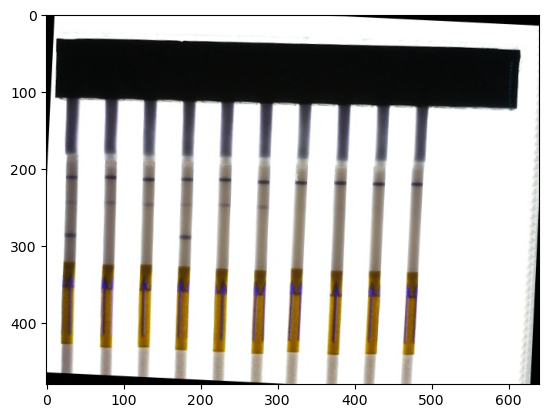

In [103]:
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)
#imageInput_blurred = cv2.GaussianBlur(imageInput, (5, 5), 0)
lab = cv2.cvtColor(imageInput, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
plt.imshow(rotated_image)

/var/folders/gl/xp97kxjs0ys5qy6zk2zvvp4m0000gn/T/ipykernel_71010/2743232123.py:24: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


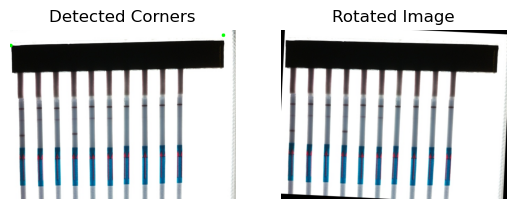

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
Img = "recent_correct_data/LFA_Br1_Cst1.jpg"
imageInput = cv2.imread(Img)

# Convert to grayscale
gray = cv2.cvtColor(imageInput, cv2.COLOR_BGR2GRAY)

# Apply threshold to isolate the black rectangle
_, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Invert to focus on dark areas

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Identify the largest contour, assuming it's the black rectangle
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding rectangle's corners
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Sort corners to find top-left and top-right points
sorted_box = sorted(box, key=lambda x: x[1])  # Sort by y-coordinate to get top corners
top_left, top_right = sorted(sorted_box[:2], key=lambda x: x[0])  # Sort by x-coordinate for left and right

# Calculate angle for rotation
delta_y = top_right[1] - top_left[1]
delta_x = top_right[0] - top_left[0]
angle = np.degrees(np.arctan2(delta_y, delta_x))

# Get image center and rotate to align rectangle horizontally
(h, w) = imageInput.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(imageInput, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

# Display original with detected corners and rotated result
for point in [top_left, top_right]:
    cv2.circle(imageInput, tuple(point), 5, (0, 255, 0), -1)  # Draw detected corner points

# Display the images
plt.subplot(1, 2, 1)
plt.title("Detected Corners")
plt.imshow(cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Rotated Image")
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()
